<a href="https://colab.research.google.com/github/tsyet12/Pgraph/blob/main/P_graph_Example_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install git+https://github.com/tsyet12/Pgraph --quiet

In [19]:
#import all libraries
from Pgraph.Pgraph import Pgraph #This is our Pgraph library
import networkx as nx
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree._tree import TREE_LEAF, TREE_UNDEFINED

In [13]:
## Get the data #####

data=pd.read_csv('Hydrates2.csv')
data=data.drop([0,1])
data.iloc[:,6]=data.iloc[:,6].where(data.iloc[:,6]!=2)
data=data.dropna()
data=data.iloc[:-1,:]
X=data.iloc[:,1:6]
y=data.iloc[:,6]
feature_names=list(data.columns)[1:6]

In [14]:
#Some useful functions for pruning

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        inner_tree.feature[index] = TREE_UNDEFINED


def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)
    return mdl


In [16]:
##### TRAIN DECISION TREE AND LOOK AT ACCURACY METRICS #####
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=0)
clf = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes=None,max_depth=7 , random_state=0)
clf.fit(X_train, y_train)
clf=prune_duplicate_leaves(clf)   
y_pred=clf.predict(X_test)

print("Accuracy (Train):",metrics.accuracy_score(y_train, clf.predict(X_train)))
print("Accuracy (Test):",metrics.accuracy_score(y_test, y_pred))

Accuracy (Train): 0.8014809751651857
Accuracy (Test): 0.8019822282980178


In [20]:
##### STEP 1 : Problem Specification ######

n_nodes = clf.tree_.node_count
children_left = clf.tree_.children_left
children_right = clf.tree_.children_right
feature = clf.tree_.feature
threshold = clf.tree_.threshold
value=clf.classes_[[np.argmax(x) for x in clf.tree_.value]]
classes=clf.classes_

node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, 0)]  # start with the root node id (0) and its depth (0)


while len(stack) > 0:
    # `pop` ensures each node is only visited once
    node_id, depth = stack.pop()
    #print(node_id,depth)
    node_depth[node_id] = depth

    is_split_node = children_left[node_id] != children_right[node_id]
    # If a split node, append left and right children and depth to `stack`
    # so we can loop through them
    if is_split_node:
        stack.append((children_left[node_id], depth + 1))
        stack.append((children_right[node_id], depth + 1))

    else:
        is_leaves[node_id] = True

G = nx.DiGraph()

ME=[]
## Unique Features as Input Material Nodes
unique_features=list(set(feature))
unique_features=[x for x in unique_features if x>=0]
global_count=n_nodes+1

for x in unique_features:
    G.add_node("M"+str(global_count),names=feature_names[x],type='intermediate',flow_rate_lower_bound=0, flow_rate_upper_bound=1000000000000,price=0)
    G.add_node("O"+str(global_count),names=feature_names[x])
    G.add_edge("M"+str(global_count),"O"+str(global_count), weight = 1, prices=0)
    global_count=global_count+1

leaf=[-2]*len(classes)

for i in range(n_nodes):
    if is_leaves[i] or feature[i]==-2: #leave or pruned
        if i in children_left or i in children_right:
            decision=int(value[i])
            if leaf[decision]>=0: 
                G.add_edge("O"+str(i),"M"+str(leaf[decision]), weight = 1, prices=0)
            else:
                G.add_edge("O"+str(i),"M"+str(i), weight = 1, prices=0)
                G.add_node("M"+str(i),names=str(decision),type='intermediate',flow_rate_lower_bound=0, flow_rate_upper_bound=1000000000000,price=0.0001)
                leaf[decision]=i
    else:
        node=i
        features=feature[i]
        feature_idx=unique_features.index(features)
        left=children_left[i]
        right=children_right[i]
        thresholds=threshold[i]
        suc_type=None
        suc_list=list(G.successors("O"+str(feature_idx+n_nodes+1)))
        if suc_list != []:
            try:
                suc_type=G.nodes()[suc_list[0]]['type']
            except:
                pass #suc_type=None
        if suc_type!='intermediate':        
            G.add_edge("O"+str(feature_idx+n_nodes+1),"M"+str(node), weight = 1, prices=0)
            G.add_node("M"+str(node),names="M"+str(node),type='intermediate',flow_rate_lower_bound=0, flow_rate_upper_bound=0,price=0)
            G.add_edge("M"+str(node),"O"+str(node), weight = 1, prices=0)
        else:
            G.add_edge(suc_list[0],"O"+str(node), weight = 1, prices=0)
        
        
        G.add_node("O"+str(node),names="O"+str(node))
        
        
        G.add_edge("O"+str(node),"M"+str(global_count), weight = 1, prices=0) 
        G.add_node("M"+str(global_count),names="M"+str(global_count),type='intermediate',flow_rate_lower_bound=0, flow_rate_upper_bound=1000000000000)
        
        
        #left
        G.add_edge("M"+str(global_count),"O"+str(global_count+1), weight = 1, prices=0)
        G.add_node("O"+str(global_count+1),names="O"+str(global_count+1),capacity_lower_bound=0, capacity_upper_bound=thresholds)
        G.add_edge("O"+str(global_count+1),"M"+str(global_count+1), weight = 1, prices=0)
        G.add_node("M"+str(global_count+1),names="M"+str(global_count+1),type='intermediate',flow_rate_lower_bound=0, flow_rate_upper_bound=1000000000000,price=0)
        G.add_edge("M"+str(global_count+1),"O"+str(left), weight = 0.001, prices=0)
        G.add_node("O"+str(left),names="O"+str(left),capacity_lower_bound=0, capacity_upper_bound=1000000000000)
        
        #right
        G.add_edge("M"+str(global_count),"O"+str(global_count+2), weight = 1, prices=0)
        G.add_node("O"+str(global_count+2),names="O"+str(global_count+2),capacity_lower_bound=thresholds+0.001, capacity_upper_bound=1000000000000)
        G.add_edge("O"+str(global_count+2),"M"+str(global_count+2), weight = 1, prices=0)
        G.add_node("M"+str(global_count+2),names="M"+str(global_count+2),type='intermediate',flow_rate_lower_bound=0, flow_rate_upper_bound=1000000000000,price=0)
        G.add_edge("M"+str(global_count+2),"O"+str(right), weight = 0.001, prices=0)
        G.add_node("O"+str(right),names="O"+str(right),capacity_lower_bound=0, capacity_upper_bound=1000000000000)        
        
        ME.append(["O"+str(global_count+1),"O"+str(global_count+2)])
        global_count=global_count+3
#############################

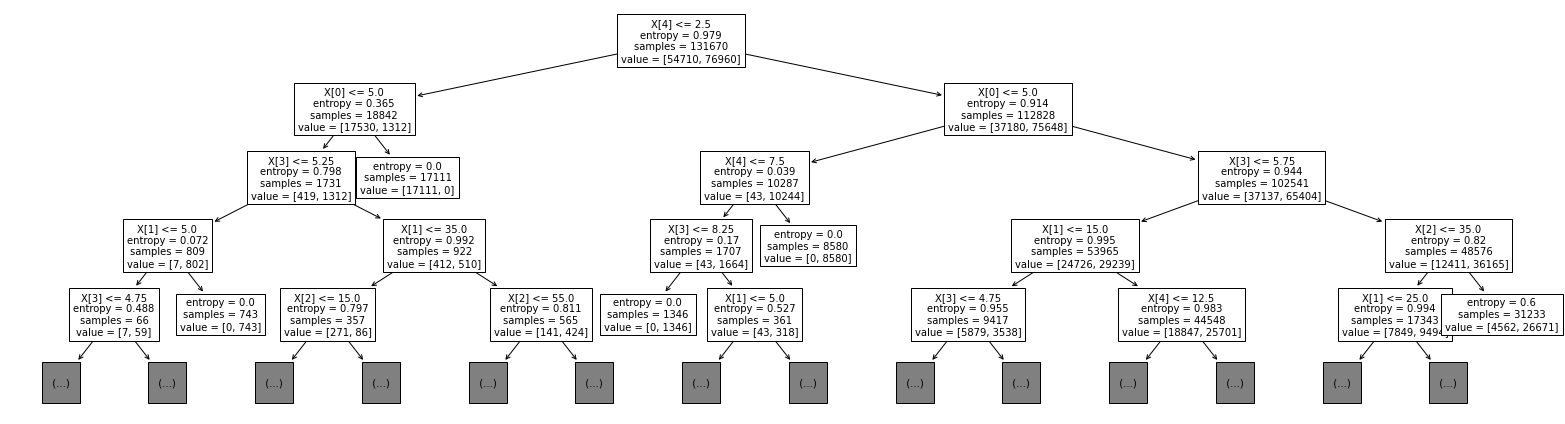

In [29]:
###Plot the decision Tree (Up to depth of 4)###
plt.figure(figsize=(22,6))
tree.plot_tree(clf,max_depth=4,fontsize=10)
plt.tight_layout()
plt.show()

In [36]:
#### SETUP P-graph problem and export to P-graph ####
P=Pgraph(problem_network=G, mutual_exclusion=ME, solver="INSIDEOUT",max_sol=100)
P.to_studio(path='./',file_name='pg.pgsx',verbose=False)


'<?xml version="1.0" encoding="utf-16"?>\n<PGraph xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xmlns:xsd="http://www.w3.org/2001/XMLSchema" Type="PNS" Visible="true" PeriodExtension="true">\n  <Default>\n    <Material>\n      <FlowRateLowerBound>0</FlowRateLowerBound>\n      <FlowRateUpperBound>1000000000</FlowRateUpperBound>\n      <Price>0</Price>\n      <Type>1</Type>\n      <Deadline>31536000</Deadline>\n      <EarliestAvability>0</EarliestAvability>\n      <StorageStrategy>default</StorageStrategy>\n    </Material>\n    <OperatingUnit>\n      <OperatingFixCost>0</OperatingFixCost>\n      <InvestmentFixCost>0</InvestmentFixCost>\n      <OpUnitFixCost>0</OpUnitFixCost>\n      <OperatingPropCost>0</OperatingPropCost>\n      <InvestmentPropCost>0</InvestmentPropCost>\n      <OpUnitPropCost>0</OpUnitPropCost>\n      <CapacityLowerBound>0</CapacityLowerBound>\n      <CapacityUpperBound>1000000000</CapacityUpperBound>\n      <PaybackPeriod>10</PaybackPeriod>\n      <WorkingHours

In [38]:
from google.colab import files
files.download('pg.pgsx')  #Download to add resource optimization manually
#Note: Manual operation is just for demonstration, you can also automate it if you want.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>